In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    #img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, label

Num GPUs Available:  1


In [6]:
tf.version

NameError: name '__tf' is not defined

In [2]:
img_height = 224
img_width = 224

epoch = 50
batch_size = 32

base_dir = r'C:\Users\Szymon\CIFAR-100'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

50000
10000
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
# AlexNet
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
    ])

# AlexNet
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)      

In [4]:
train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time)

Epoch 1/50
1562/1562 [==============================] - 198s 119ms/step - loss: 6.5758 - accuracy: 0.1343 - val_loss: 4.1534 - val_accuracy: 0.2300
Epoch 2/50
1562/1562 [==============================] - 188s 120ms/step - loss: 3.6586 - accuracy: 0.2704 - val_loss: 2.9270 - val_accuracy: 0.3185
Epoch 3/50
1562/1562 [==============================] - 187s 120ms/step - loss: 2.5982 - accuracy: 0.3587 - val_loss: 2.4803 - val_accuracy: 0.3814
Epoch 4/50
1562/1562 [==============================] - 185s 118ms/step - loss: 2.2216 - accuracy: 0.4283 - val_loss: 2.4982 - val_accuracy: 0.3838
Epoch 5/50
1562/1562 [==============================] - 181s 116ms/step - loss: 1.9036 - accuracy: 0.4971 - val_loss: 2.9522 - val_accuracy: 0.4050
Epoch 6/50
1562/1562 [==============================] - 182s 116ms/step - loss: 1.7191 - accuracy: 0.5449 - val_loss: 2.3497 - val_accuracy: 0.4515
Epoch 7/50
1562/1562 [==============================] - 182s 116ms/step - loss: 1.5476 - accuracy: 0.5851 - val_

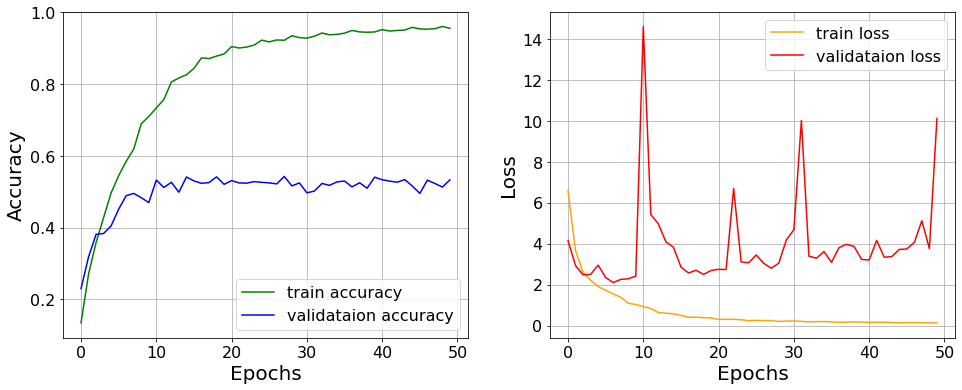

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [6]:
# 7Net

"""
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
    ])

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()
"""

'\ndata_augmentation = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    layers.experimental.preprocessing.RandomFlip(\'horizontal\'),\n    layers.experimental.preprocessing.RandomRotation(0.2),\n    layers.experimental.preprocessing.RandomContrast(0.1),\n    layers.experimental.preprocessing.RandomZoom(0.1)\n    ])\n\nmodel = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    #data_augmentation,\n    \n    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),\n    layers.Dropout(0.1),\n    \n    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),\n    layers.Dropout(0.2),\n    \n    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),\n    layers.Batch

In [5]:
# Alexnet
"""
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
    ])

# AlexNet
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()
"""

'\ndata_augmentation = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    layers.experimental.preprocessing.RandomFlip(\'horizontal\'),\n    layers.experimental.preprocessing.RandomRotation(0.2),\n    layers.experimental.preprocessing.RandomContrast(0.1),\n    layers.experimental.preprocessing.RandomZoom(0.1)\n    ])\n\n# AlexNet\nmodel = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    #data_augmentation,\n    \n    layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),\n    \n    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),\n    \n    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),\n    layers.Ba

In [4]:
#7Net

#train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
#val_dataset = val_dataset.batch(batch_size)
#train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
#val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

#start_time= time.perf_counter()
#model_train = model.fit(
    #train_dataset,
    #steps_per_epoch = int((train_num_files)/batch_size),
    #validation_data = val_dataset,
    #validation_steps = int(val_num_files/batch_size),
    #epochs=epoch)

#print(time.perf_counter()-start_time)

Epoch 1/50
1562/1562 [==============================] - 403s 252ms/step - loss: 4.1923 - accuracy: 0.0895 - val_loss: 4.1257 - val_accuracy: 0.0605
Epoch 2/50
1562/1562 [==============================] - 395s 253ms/step - loss: 3.4372 - accuracy: 0.1781 - val_loss: 3.1430 - val_accuracy: 0.2504
Epoch 3/50
1562/1562 [==============================] - 386s 247ms/step - loss: 3.0983 - accuracy: 0.2397 - val_loss: 2.7786 - val_accuracy: 0.3321
Epoch 4/50
1562/1562 [==============================] - 384s 246ms/step - loss: 2.8230 - accuracy: 0.2913 - val_loss: 2.5128 - val_accuracy: 0.3898
Epoch 5/50
1562/1562 [==============================] - 380s 243ms/step - loss: 2.6230 - accuracy: 0.3314 - val_loss: 2.5309 - val_accuracy: 0.3678
Epoch 6/50
1562/1562 [==============================] - 379s 242ms/step - loss: 2.4955 - accuracy: 0.3549 - val_loss: 2.3503 - val_accuracy: 0.4022
Epoch 7/50
1562/1562 [==============================] - 377s 241ms/step - loss: 2.4050 - accuracy: 0.3802 - val_

KeyboardInterrupt: 